In [92]:
import pickle
import networkx as nx

#from scripts.correlation.func.dev.process_glycan import new_g


def load_data_pdb():
    flex_data_path = '/Users/xakdze/PycharmProjects/GlyContact_analyses/data/glycan_graphs.pkl'

    """Load glycan flexibility data and binding data."""
    with open(flex_data_path, 'rb') as file:
        flex_data = pickle.load(file)
    return flex_data



In [101]:
def convert_pdb_graph_to_glycowork1(g):
    """
    Converts a PDB-format graph to glycowork format.
    Args:
        g (nx.Graph): Input graph in PDB format with Monosaccharide and score attributes
    Returns:
        nx.Graph: Converted graph in glycowork format with monosaccharide/linkage split into separate nodes
    """
    new_g = nx.Graph()

    # Find reducing end (node connected to -R node 1)
    reducing_end = None
    for n in g.neighbors(1):
        reducing_end = n
        break

    if reducing_end is None:
        raise ValueError("Could not find reducing end (node connected to -R)")

    # Get node list in DFS order starting from reducing end (excluding -R node)
    nodes = [n for n in nx.dfs_preorder_nodes(g, reducing_end) if n != 1]

    # Create mapping dict
    mapping = {}
    mapping[1] = []  # -R maps to nothing

    # Calculate highest node number
    max_num = 2 * (len(g.nodes) - 2)

    # Map reducing end to highest number
    mapping[reducing_end] = [max_num]

    # Map rest of nodes in reverse order
    curr_num = 0
    for node in reversed(nodes[1:]):  # Skip reducing end
        mapping[node] = [curr_num, curr_num + 1]
        curr_num += 2

    # Create nodes in new graph
    for old_node, new_nodes in mapping.items():
        if not new_nodes:  # Skip -R
            continue

        # Get numerical attributes
        attrs = {k: v for k, v in g.nodes[old_node].items()
                if k not in ['Monosaccharide', 'string_labels']}
        mono_link = g.nodes[old_node]['Monosaccharide']

        if len(new_nodes) == 1:  # Reducing end
            mono = mono_link.split('(')[0]
            new_g.add_node(new_nodes[0], string_labels=mono, **attrs)
        else:  # Normal nodes
            mono = mono_link.split('(')[0]
            link = mono_link.split('(')[1][:-1]

            new_g.add_node(new_nodes[0], string_labels=mono, **attrs)
            new_g.add_node(new_nodes[1], string_labels=link, **attrs)
            new_g.add_edge(new_nodes[0], new_nodes[1])

    # Add edges between components
    for old_u, old_v in g.edges():
        new_u = mapping.get(old_u, [])
        new_v = mapping.get(old_v, [])

        if not new_u or not new_v:  # Skip if either is -R
            continue

        if len(new_u) == 1:  # u is reducing end
            u_node = new_u[0]
        else:
            u_node = new_u[0]  # Use monosaccharide node

        if len(new_v) == 1:  # v is reducing end
            v_node = new_v[0]
        else:
            v_node = new_v[1]  # Use linkage node

        new_g.add_edge(u_node, v_node)

    return new_g

def convert_pdb_graph_to_glycowork2(g):
    """
    Converts a PDB-format graph to glycowork format.
    Args:
        g (nx.Graph): Input graph in PDB format with Monosaccharide and score attributes
    Returns:
        nx.Graph: Converted graph in glycowork format with monosaccharide/linkage split into separate nodes
    """
    new_g = nx.Graph()

    # Find reducing end (node connected to -R node 1)
    reducing_end = None
    for n in g.neighbors(1):
        reducing_end = n
        break

    if reducing_end is None:
        raise ValueError("Could not find reducing end (node connected to -R)")

    # Get node list in DFS order starting from reducing end (excluding -R node)
    nodes = [n for n in nx.dfs_preorder_nodes(g, reducing_end) if n != 1]

    # Create mapping dict
    mapping = {}
    mapping[1] = []  # -R maps to nothing

    # Calculate highest node number
    max_num = 2 * (len(g.nodes) - 2)

    # Map reducing end to highest number
    mapping[reducing_end] = [max_num]

    # Map rest of nodes in reverse order
    curr_num = 0
    for node in nodes:  # Include all nodes
        mono_link = g.nodes[node]['Monosaccharide']
        mono = mono_link.split('(')[0]
        link = mono_link.split('(')[1][:-1] if '(' in mono_link else None

        mapping[node] = [curr_num]
        if link:  # Add linkage if present
            mapping[node].append(curr_num + 1)
            curr_num += 2
        else:
            curr_num += 1

    # Create nodes in new graph
    for old_node, new_nodes in mapping.items():
        if not new_nodes:  # Skip -R
            continue

        # Get numerical attributes
        attrs = {k: v for k, v in g.nodes[old_node].items() if k != 'Monosaccharide'}
        mono_link = g.nodes[old_node]['Monosaccharide']

        if len(new_nodes) == 1:  # Single node
            mono = mono_link.split('(')[0]
            new_g.add_node(new_nodes[0], string_labels=mono, **attrs)
        else:  # Node and linkage
            mono = mono_link.split('(')[0]
            link = mono_link.split('(')[1][:-1]

            new_g.add_node(new_nodes[0], string_labels=mono, **attrs)
            new_g.add_node(new_nodes[1], string_labels=link, **attrs)
            new_g.add_edge(new_nodes[0], new_nodes[1])

    # Add edges between components
    for old_u, old_v in g.edges():
        new_u = mapping.get(old_u, [])
        new_v = mapping.get(old_v, [])

        if not new_u or not new_v:  # Skip if either is -R
            continue

        # Use the correct node for the edge
        u_node = new_u[0]
        v_node = new_v[0]
        new_g.add_edge(u_node, v_node)

    return new_g

def convert_pdb_graph_to_glycowork3(g):
    """
    Converts a PDB-format graph to glycowork format.
    Args:
        g (nx.Graph): Input graph in PDB format with Monosaccharide and score attributes.
    Returns:
        nx.Graph: Converted graph in glycowork format with monosaccharide/linkage split into separate nodes.
    """
    new_g = nx.Graph()

    # Identify the reducing end (connected to -R node, typically node 1)
    reducing_end = next((n for n in g.neighbors(1)), None)
    if reducing_end is None:
        raise ValueError("Could not find reducing end (node connected to -R).")

    # Sort nodes by connection to ensure correct order
    sorted_nodes = sorted(g.nodes, key=lambda n: (n != reducing_end, n))

    # Map old nodes to new nodes in glycowork format
    mapping = {}
    current_index = 0  # Track the current index for the new nodes

    for node in sorted_nodes:
        # Retrieve Monosaccharide attribute and split it
        mono_link = g.nodes[node].get('Monosaccharide', '')
        if '(' in mono_link and ')' in mono_link:
            mono = mono_link.split('(')[0]
            link = mono_link.split('(')[1][:-1]
        else:
            mono = mono_link
            link = None

        # Assign the current node's monosaccharide
        mono_node = current_index
        new_g.add_node(mono_node, string_labels=mono, **g.nodes[node])
        mapping[node] = [mono_node]
        current_index += 1

        # Assign the linkage as a separate node if present
        if link:
            link_node = current_index
            new_g.add_node(link_node, string_labels=link, **g.nodes[node])
            new_g.add_edge(mono_node, link_node)
            mapping[node].append(link_node)
            current_index += 1

    # Add edges between mapped nodes
    for old_u, old_v in g.edges():
        if old_u not in mapping or old_v not in mapping:
            continue  # Skip edges involving unmapped nodes

        # Connect monosaccharide nodes between components
        u_node = mapping[old_u][0]  # First node in mapping is the monosaccharide
        v_node = mapping[old_v][0]  # First node in mapping is the monosaccharide
        new_g.add_edge(u_node, v_node)

    return new_g

def convert_pdb_graph_to_glycowork4(g):
    """
    Converts a PDB-format graph to glycowork format.
    Args:
        g (nx.Graph): Input graph in PDB format with Monosaccharide and score attributes.
    Returns:
        nx.Graph: Converted graph in glycowork format with monosaccharide/linkage split into separate nodes.
    """
    new_g = nx.Graph()

    # Identify the reducing end (connected to -R node, typically node 1)
    reducing_end = next((n for n in g.neighbors(1)), None)
    if reducing_end is None:
        raise ValueError("Could not find reducing end (node connected to -R).")

    # Traverse nodes starting from the reducing end
    visited = set()
    stack = [reducing_end]
    mapping = {}
    current_index = 0

    while stack:
        node = stack.pop()
        if node in visited:
            continue
        visited.add(node)

        # Retrieve Monosaccharide attribute and split it
        mono_link = g.nodes[node].get('Monosaccharide', '')
        if '(' in mono_link and ')' in mono_link:
            mono = mono_link.split('(')[0]
            link = mono_link.split('(')[1][:-1]
        else:
            mono = mono_link
            link = None

        # Assign the current node's monosaccharide
        mono_node = current_index
        new_g.add_node(mono_node, string_labels=mono, **g.nodes[node])
        mapping[node] = [mono_node]
        current_index += 1

        # Assign the linkage as a separate node if present
        if link:
            link_node = current_index
            new_g.add_node(link_node, string_labels=link, **g.nodes[node])
            new_g.add_edge(mono_node, link_node)
            mapping[node].append(link_node)
            current_index += 1

        # Add neighbors to the stack
        for neighbor in g.neighbors(node):
            if neighbor not in visited and neighbor != 1:  # Skip -R node
                stack.append(neighbor)

    # Add edges between mapped nodes
    for old_u, old_v in g.edges():
        if old_u not in mapping or old_v not in mapping:
            continue  # Skip edges involving unmapped nodes

        # Connect monosaccharide nodes between components
        u_node = mapping[old_u][0]  # First node in mapping is the monosaccharide
        v_node = mapping[old_v][0]  # First node in mapping is the monosaccharide
        new_g.add_edge(u_node, v_node)

    return new_g

def convert_pdb_graph_to_glycowork5(g):
    """
    Converts a PDB-format graph to glycowork format.
    Args:
        g (nx.Graph): Input graph in PDB format with Monosaccharide and score attributes.
    Returns:
        nx.Graph: Converted graph in glycowork format with monosaccharide/linkage split into separate nodes.
    """
    new_g = nx.Graph()

    # Identify the reducing end (connected to -R node, typically node 1)
    reducing_end = next((n for n in g.neighbors(1)), None)
    if reducing_end is None:
        raise ValueError("Could not find reducing end (node connected to -R).")

    # Create a mapping from PDB nodes to glycowork nodes
    pdb_to_glyco_mapping = {}
    current_index = 0  # Tracks the current index for glycowork nodes

    # Function to add a node and map it
    def add_node(pdb_node, mono_link):
        nonlocal current_index
        # Parse monosaccharide and linkage
        if '(' in mono_link and ')' in mono_link:
            mono = mono_link.split('(')[0]
            link = mono_link.split('(')[1][:-1]
        else:
            mono = mono_link
            link = None

        # Add monosaccharide node
        mono_node = current_index
        new_g.add_node(mono_node, string_labels=mono, **g.nodes[pdb_node])
        pdb_to_glyco_mapping[pdb_node] = [mono_node]
        current_index += 1

        # Add linkage node if applicable
        if link:
            link_node = current_index
            new_g.add_node(link_node, string_labels=link, **g.nodes[pdb_node])
            new_g.add_edge(mono_node, link_node)
            pdb_to_glyco_mapping[pdb_node].append(link_node)
            current_index += 1

    # Start with the reducing end
    stack = [(None, reducing_end)]  # (parent, current_node)
    visited = set()

    while stack:
        parent, current = stack.pop()
        if current in visited:
            continue
        visited.add(current)

        # Add the current node to the glycowork graph
        mono_link = g.nodes[current].get('Monosaccharide', '')
        add_node(current, mono_link)

        # Add edges to parent node in glycowork graph
        if parent is not None:
            parent_nodes = pdb_to_glyco_mapping[parent]
            current_nodes = pdb_to_glyco_mapping[current]

            # Connect the last linkage node of the parent to the first monosaccharide node of the current node
            new_g.add_edge(parent_nodes[-1], current_nodes[0])

        # Add neighbors to the stack
        for neighbor in g.neighbors(current):
            if neighbor != 1 and neighbor not in visited:  # Skip the reducing end marker (-R)
                stack.append((current, neighbor))

    return new_g

#thsi wokred for teh 1Fuc glycan
def convert_pdb_graph_to_glycowork6(g):
    """
    Converts a PDB-format graph to a Glycowork-format graph.

    Args:
        g (nx.Graph): Input PDB graph with Monosaccharide and other attributes.

    Returns:
        nx.Graph: Converted Glycowork graph.
    """
    new_g = nx.Graph()

    # Step 1: Identify nodes and prioritize the desired node (Fuc in this case)
    fuc_node = None
    for node, attrs in g.nodes(data=True):
        if "Fuc" in attrs.get("Monosaccharide", ""):
            fuc_node = node
            break

    if fuc_node is None:
        raise ValueError("Fuc not found in the PDB graph.")

    # Step 2: Perform traversal, starting with Fuc
    stack = [(None, fuc_node)]  # (parent, current)
    visited = set()
    mapping = {}
    current_index = 0

    def add_node(node, label):
        """Adds a node to the Glycowork graph."""
        nonlocal current_index
        new_g.add_node(current_index, string_labels=label, **g.nodes[node])
        mapping[node] = current_index
        current_index += 1
        return current_index - 1

    while stack:
        parent, current = stack.pop()
        if current in visited:
            continue
        visited.add(current)

        # Parse Monosaccharide and linkage
        mono_link = g.nodes[current].get("Monosaccharide", "")
        if "(" in mono_link and ")" in mono_link:
            mono = mono_link.split("(")[0]
            link = mono_link.split("(")[1][:-1]
        else:
            mono = mono_link
            link = None

        # Add monosaccharide node
        mono_node = add_node(current, mono)

        # Add linkage node if applicable
        if link:
            link_node = add_node(current, link)
            new_g.add_edge(mono_node, link_node)

        # Add edges to parent
        if parent is not None and parent in mapping:
            parent_node = mapping[parent]
            new_g.add_edge(parent_node, mono_node)

        # Add neighbors to stack
        for neighbor in g.neighbors(current):
            if neighbor not in visited and neighbor != 1:  # Skip the reducing end marker (-R)
                stack.append((current, neighbor))

    return new_g

def convert_pdb_graph_to_glycowork(g):
    """
    Converts a PDB-format graph to Glycowork format, handling complex branching structures.

    Args:
        g (nx.Graph): Input graph in PDB format with Monosaccharide and other attributes.

    Returns:
        nx.Graph: Converted Glycowork graph.
    """
    new_g = nx.Graph()

    # Identify the starting node (e.g., Fuc for prioritization or reducing end marker)
    start_node = None
    for node, attrs in g.nodes(data=True):
        if "Fuc" in attrs.get("Monosaccharide", ""):
            start_node = node
            break

    if start_node is None:
        raise ValueError("Fuc not found in the PDB graph.")

    # Stack for traversal
    stack = [(None, start_node)]  # (parent, current)
    visited = set()
    mapping = {}
    current_index = 0

    def add_node(pdb_node, label):
        """Adds a node to the Glycowork graph."""
        nonlocal current_index
        new_g.add_node(current_index, string_labels=label, **g.nodes[pdb_node])
        mapping[(pdb_node, label)] = current_index
        current_index += 1
        return current_index - 1

    while stack:
        parent, current = stack.pop()
        if current in visited:
            continue
        visited.add(current)

        # Parse Monosaccharide and linkage
        mono_link = g.nodes[current].get("Monosaccharide", "")
        if "(" in mono_link and ")" in mono_link:
            mono = mono_link.split("(")[0]
            link = mono_link.split("(")[1][:-1]
        else:
            mono = mono_link
            link = None

        # Add monosaccharide node
        if (current, mono) not in mapping:
            mono_node = add_node(current, mono)
        else:
            mono_node = mapping[(current, mono)]

        # Add linkage node if applicable
        if link:
            if (current, link) not in mapping:
                link_node = add_node(current, link)
                new_g.add_edge(mono_node, link_node)
            else:
                link_node = mapping[(current, link)]

        # Add edges to parent
        if parent is not None:
            parent_mono = g.nodes[parent].get("Monosaccharide", "").split("(")[0]
            parent_node = mapping.get((parent, parent_mono))
            if parent_node is not None:
                new_g.add_edge(parent_node, mono_node)

        # Add neighbors to stack
        for neighbor in g.neighbors(current):
            if neighbor not in visited:
                stack.append((current, neighbor))

    return new_g





In [32]:
new_g = convert_pdb_graph_to_glycowork(flex_data['Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc'])
print(new_g.nodes())
print(new_g.nodes(data=True))

[6, 0, 1, 2, 3, 4, 5]
[(6, {'string_labels': 'GlcNAc', 'Mean Score': 2.1611419503344225, 'Median Score': 2.158357013016939, 'Weighted Score': 2.1689804389134233, 'weighted_mean_flexibility': 0.42260358035803125}), (0, {'string_labels': 'Fuc', 'Mean Score': 2.157345515722409, 'Median Score': 2.18301942886319, 'Weighted Score': 2.170830920556838, 'weighted_mean_flexibility': 0.9650379437943786}), (1, {'string_labels': 'a1-2', 'Mean Score': 2.157345515722409, 'Median Score': 2.18301942886319, 'Weighted Score': 2.170830920556838, 'weighted_mean_flexibility': 0.9650379437943786}), (2, {'string_labels': 'Gal', 'Mean Score': 1.6548255177214741, 'Median Score': 1.666945289936848, 'Weighted Score': 1.6512541135026229, 'weighted_mean_flexibility': 0.48598685868586866}), (3, {'string_labels': 'b1-4', 'Mean Score': 1.6548255177214741, 'Median Score': 1.666945289936848, 'Weighted Score': 1.6512541135026229, 'weighted_mean_flexibility': 0.48598685868586866}), (4, {'string_labels': 'Fuc', 'Mean Score

In [33]:
old_g= flex_data['Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc']
print(old_g.nodes())
print(old_g.nodes(data=True))

[3, 2, 5, 4, 1]
[(3, {'Monosaccharide': 'Fuc(a1-3)', 'Mean Score': 1.763120694970712, 'Median Score': 1.749811589717865, 'Weighted Score': 1.7597374506394274, 'weighted_mean_flexibility': 0.6866602260226038}), (2, {'Monosaccharide': 'GlcNAc(b1-1)', 'Mean Score': 2.1611419503344225, 'Median Score': 2.158357013016939, 'Weighted Score': 2.1689804389134233, 'weighted_mean_flexibility': 0.42260358035803125}), (5, {'Monosaccharide': 'Fuc(a1-2)', 'Mean Score': 2.157345515722409, 'Median Score': 2.18301942886319, 'Weighted Score': 2.170830920556838, 'weighted_mean_flexibility': 0.9650379437943786}), (4, {'Monosaccharide': 'Gal(b1-4)', 'Mean Score': 1.6548255177214741, 'Median Score': 1.666945289936848, 'Weighted Score': 1.6512541135026229, 'weighted_mean_flexibility': 0.48598685868586866}), (1, {'Monosaccharide': '-R', 'Mean Score': 0.4869304597377777, 'Median Score': 0.47832901775836945, 'Weighted Score': 0.48961252550838447, 'weighted_mean_flexibility': 0.558732173217323})]


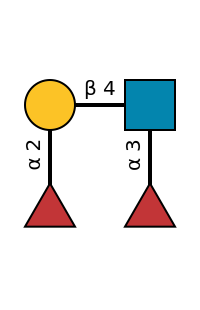

In [34]:
from glycowork.motif.draw import GlycoDraw

GlycoDraw("Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc")


In [100]:
from glycowork.motif.graph import subgraph_isomorphism
import pandas as pd
flex_data_path = '/Users/xakdze/PycharmProjects/GlyContact_analyses/data/glycan_graphs.pkl'
binding_data_path = '/Users/xakdze/PycharmProjects/GlyContact_analyses/data/20241206_glycan_binding.csv'

def load_data():
    """Load glycan flexibility data and binding data."""
    with open(flex_data_path, 'rb') as file:
        flex_data_pdb_g = pickle.load(file)

    flex_data = {}
    invalid_graphs = []  # List to store invalid graphs

    for glycan, graph in zip(flex_data_pdb_g.keys(), flex_data_pdb_g.values()):  # Ensure correct glycan-graph pairing
        try:
            # Skip invalid graphs before converting
            if not hasattr(graph, 'neighbors') or not graph:
                invalid_graphs.append(glycan)
                continue

            converted_graph = convert_pdb_graph_to_glycowork(graph)
            flex_data[glycan] = converted_graph  # Store the converted graph for the glycan

        except Exception as e:
            print(f"Error converting graph for glycan {glycan}: {e}")

    # Load binding data
    binding_df = pd.read_csv(binding_data_path)

    return flex_data, binding_df, invalid_graphs

flex_data, binding_df, invalid_graphs = load_data()

def process_glycan_with_motifs(matched_glycan: str,
                               properties: dict,
                               flex_data: dict[str, nx.Graph]):
    """
    Process a glycan string to find nodes matching binding motifs and calculate metrics.
    Handles both single and multiple binding motifs.

    Args:
        matched_glycan (str): Identifier of the glycan to process.
        properties (dict): Properties including motifs and termini lists.
        flex_data (dict): Dictionary mapping glycan identifiers to graphs.

    Returns:
        tuple: Matching monosaccharides, SASA-weighted scores, flexibility-weighted scores, and found motifs.
    """
    matching_monosaccharides, sasa_weighted, flexibility_weighted, found_motifs = [], [], [], []

    motifs = properties.get("motif", [])
    termini_list = properties.get("termini_list", [])

    for motif, termini in zip(motifs, termini_list):
        try:
            # Perform subgraph isomorphism
            try:
                is_present, matched_nodes = subgraph_isomorphism(
                    matched_glycan, motif,
                    return_matches=True,
                    termini_list=termini
                )
                if not is_present:
                    continue
            except Exception as e:
                print(f"Subgraph isomorphism error for glycan {matched_glycan} with motif {motif}: {e}")
                continue

            found_motifs.append(motif)
            print(f"Processing motif: {motif} for glycan: {matched_glycan}")

            matched_nodes = [node for sublist in matched_nodes for node in sublist] \
                if isinstance(matched_nodes[0], list) else matched_nodes
            print(f"Matched nodes: {matched_nodes}")

            # Access the graph directly from flex_data
            pdb_graph = flex_data.get(matched_glycan)
            if not pdb_graph:
                print(f"No graph found for glycan: {matched_glycan}")
                continue

            selected_mono = [node for node in matched_nodes if node in pdb_graph.nodes]
            print(f"Selected monosaccharides: {selected_mono}")

            # Extract attributes from graph nodes
            if hasattr(pdb_graph, "nodes"):
                print(f"Graph nodes: {pdb_graph.nodes(data=True)}")
                for mono in selected_mono:
                    try:
                        attributes = pdb_graph.nodes[mono]
                        matching_monosaccharides.append(attributes.get("string_labels", ""))
                        sasa_weighted.append(attributes.get("Weighted Score", 0))
                        flexibility_weighted.append(attributes.get("weighted_mean_flexibility", 0))

                        print(f"Matching monosaccharides: {matching_monosaccharides}")
                        print(f"SASA-weighted scores: {sasa_weighted}")
                        print(f"Flexibility-weighted scores: {flexibility_weighted}")
                        print("")
                    except Exception as e:
                        print(f"Error extracting attributes for node {mono} in glycan {matched_glycan}: {e}")
            else:
                print(f"Skipping invalid graph or graph with no nodes for glycan: {matched_glycan}")

        except Exception as e:
            print(f"General error processing glycan {matched_glycan} with motif {motif}: {e}")

    return matching_monosaccharides, sasa_weighted, flexibility_weighted, found_motifs

process_glycan_with_motifs(matched_glycan= "Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)]Gal(b1-4)Glc",
                            properties= {"motif": ["Fuc"],
                                         "termini_list": [["t"]]},
                            flex_data=flex_data)

Error converting graph for glycan Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc: Fuc not found in the PDB graph.
Error converting graph for glycan GlcNAc(b1-6)GalNAc: Fuc not found in the PDB graph.
Error converting graph for glycan Neu5Ac(a2-3)Gal(b1-3)GalNAc: Fuc not found in the PDB graph.
Error converting graph for glycan Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc: Fuc not found in the PDB graph.
Error converting graph for glycan Gal(b1-3)GalNAc(b1-4)Gal(b1-4)Glc: Fuc not found in the PDB graph.
Error converting graph for glycan Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Gal(b1-4)GlcNAc(b1-2)[GlcNAc(b1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc: Fuc not found in the PDB graph.
Error converting graph for glycan Ara(b1-3)Ara(b1-2)Ara(b1-2)Ara: Fuc not found in the PDB graph.
Error converting graph for glycan Neu5Ac(a2-3)Gal(

(['Fuc', 'Gal', 'Glc'],
 [1.8669023368021382, 2.1429253625935147, 2.128792897366927],
 [22.883701009899013, 21.138903229677034, 12.17857534246575],
 ['Fuc'])

In [ ]:
Graph nodes: [
            (16, {'string_labels': 'Glc', 'Mean Score': 2.0514767858432608, 'Median Score': 2.244769612327218, 'Weighted Score': 2.128792897366927, 'weighted_mean_flexibility': 12.17857534246575}),
              (0, {'string_labels': 'Fuc', 'Mean Score': 1.8676189828198404, 'Median Score': 1.8176706893136725, 'Weighted Score': 1.9261586474572951, 'weighted_mean_flexibility': 16.641286591340865}),
              (1, {'string_labels': 'a1-3', 'Mean Score': 1.8676189828198404, 'Median Score': 1.8176706893136725, 'Weighted Score': 1.9261586474572951, 'weighted_mean_flexibility': 16.641286591340865}),
              (2, {'string_labels': 'Fuc', 'Mean Score': 1.9629103216109798, 'Median Score': 2.0159400925040245, 'Weighted Score': 1.94111501673313, 'weighted_mean_flexibility': 20.127824177582237}),
              (3, {'string_labels': 'a1-2', 'Mean Score': 1.9629103216109798, 'Median Score': 2.0159400925040245, 'Weighted Score': 1.94111501673313, 'weighted_mean_flexibility': 20.127824177582237}),
              (4, {'string_labels': 'Gal', 'Mean Score': 1.7647929069120436, 'Median Score': 1.7578037350904197, 'Weighted Score': 1.7861381799561076, 'weighted_mean_flexibility': 15.575945445455453}),
              (5, {'string_labels': 'b1-4', 'Mean Score': 1.7647929069120436, 'Median Score': 1.7578037350904197, 'Weighted Score': 1.7861381799561076, 'weighted_mean_flexibility': 15.575945445455453}),
              (6, {'string_labels': 'GlcNAc', 'Mean Score': 1.6338292866479605, 'Median Score': 1.6407650627661496, 'Weighted Score': 1.59215364100916, 'weighted_mean_flexibility': 10.98267171282872}),
              (7, {'string_labels': 'b1-3', 'Mean Score': 1.6338292866479605, 'Median Score': 1.6407650627661496, 'Weighted Score': 1.59215364100916, 'weighted_mean_flexibility': 10.98267171282872}),
              (8, {'string_labels': 'Fuc', 'Mean Score': 1.81364550429862, 'Median Score': 1.891440232633613, 'Weighted Score': 1.8669023368021382, 'weighted_mean_flexibility': 22.883701009899013}),
              (9, {'string_labels': 'a1-3', 'Mean Score': 1.81364550429862, 'Median Score': 1.891440232633613, 'Weighted Score': 1.8669023368021382, 'weighted_mean_flexibility': 22.883701009899013}),
              (10, {'string_labels': 'Gal', 'Mean Score': 2.1178403232130223, 'Median Score': 2.1259297977085225, 'Weighted Score': 2.1429253625935147, 'weighted_mean_flexibility': 21.138903229677034}),
              (11, {'string_labels': 'b1-4', 'Mean Score': 2.1178403232130223, 'Median Score': 2.1259297977085225, 'Weighted Score': 2.1429253625935147, 'weighted_mean_flexibility': 21.138903229677034}),
              (12, {'string_labels': 'GlcNAc', 'Mean Score': 1.773262549820356, 'Median Score': 1.6837695762515068, 'Weighted Score': 1.7021496458169612, 'weighted_mean_flexibility': 17.064866673332663}),
              (13, {'string_labels': 'b1-6', 'Mean Score': 1.773262549820356, 'Median Score': 1.6837695762515068, 'Weighted Score': 1.7021496458169612, 'weighted_mean_flexibility': 17.064866673332663}),
              (14, {'string_labels': 'Gal', 'Mean Score': 1.0813572494313122, 'Median Score': 1.0846662780968472, 'Weighted Score': 1.0457681036238264, 'weighted_mean_flexibility': 6.275166123387661}),
              (15, {'string_labels': 'b1-4', 'Mean Score': 1.0813572494313122, 'Median Score': 1.0846662780968472, 'Weighted Score': 1.0457681036238264, 'weighted_mean_flexibility': 6.275166123387661})]

In [38]:
is_present, matched_nodes = subgraph_isomorphism(
                    "Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)]Gal(b1-4)Glc", "Fuc",
                    return_matches=True,
                    termini_list=["t"] )
print(matched_nodes)

1
[[0], [4], [8]]


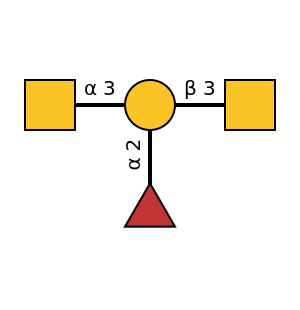

In [74]:
from glycowork.motif.draw import GlycoDraw

GlycoDraw("Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-3)GalNAc")

In [93]:
from glycowork.motif.graph import  glycan_to_nxGraph

flex_data_pdb_g=load_data_pdb()

#glycan_to_nxGraph('Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-3)GalNAc').__dict__
flex_data_pdb_g["Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-3)GalNAc"].__dict__
#flex_data["Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-3)GalNAc"].__dict__ #converted graph which is wrong

{'graph': {},
 '_node': {5: {'Monosaccharide': 'Fuc(a1-2)',
   'Mean Score': 1.7742241196567192,
   'Median Score': 1.7500426049227826,
   'Weighted Score': 1.770798686109169,
   'weighted_mean_flexibility': 1.7841829199999972},
  3: {'Monosaccharide': 'Gal(b1-3)',
   'Mean Score': 1.3651039792224764,
   'Median Score': 1.4288511350750923,
   'Weighted Score': 1.4280285533756016,
   'weighted_mean_flexibility': 0.5045951200000001},
  2: {'Monosaccharide': 'GalNAc(b1-1)',
   'Mean Score': 2.570391431148164,
   'Median Score': 2.5758022993104532,
   'Weighted Score': 2.5724899762541984,
   'weighted_mean_flexibility': 1.0605134599999986},
  1: {'Monosaccharide': '-R',
   'Mean Score': 0.4371745139360428,
   'Median Score': 0.4432986080646515,
   'Weighted Score': 0.4489135126680136,
   'weighted_mean_flexibility': 1.9624109399999994},
  4: {'Monosaccharide': 'GalNAc(a1-3)',
   'Mean Score': 3.1187803193926813,
   'Median Score': 3.120820430573076,
   'Weighted Score': 3.145775448013074,


In [ ]:
{'graph': {},
 '_node': {0: {'string_labels': 'Fuc'},
  1: {'string_labels': 'a1-2'},
  2: {'string_labels': 'GalNAc'},
  3: {'string_labels': 'a1-3'},
  4: {'string_labels': 'Gal'},
  5: {'string_labels': 'b1-3'},
  6: {'string_labels': 'GalNAc'}},
 '_adj': {0: {1: {}},
  1: {0: {}, 4: {}},
  2: {3: {}},
  3: {2: {}, 4: {}},
  4: {1: {}, 3: {}, 5: {}},
  5: {4: {}, 6: {}},
  6: {5: {}}},
 '__networkx_cache__': {},
 'edges': EdgeView([(0, 1), (1, 4), (2, 3), (3, 4), (4, 5), (5, 6)]),
 'nodes': NodeView((0, 1, 2, 3, 4, 5, 6))}

In [ ]:
{'graph': {},
 '_node': {5: {'Monosaccharide': 'Fuc(a1-2)',
   'Mean Score': 1.7742241196567192,
   'Median Score': 1.7500426049227826,
   'Weighted Score': 1.770798686109169,
   'weighted_mean_flexibility': 1.7841829199999972},
  3: {'Monosaccharide': 'Gal(b1-3)',
   'Mean Score': 1.3651039792224764,
   'Median Score': 1.4288511350750923,
   'Weighted Score': 1.4280285533756016,
   'weighted_mean_flexibility': 0.5045951200000001},
  2: {'Monosaccharide': 'GalNAc(b1-1)',
   'Mean Score': 2.570391431148164,
   'Median Score': 2.5758022993104532,
   'Weighted Score': 2.5724899762541984,
   'weighted_mean_flexibility': 1.0605134599999986},
  1: {'Monosaccharide': '-R',
   'Mean Score': 0.4371745139360428,
   'Median Score': 0.4432986080646515,
   'Weighted Score': 0.4489135126680136,
   'weighted_mean_flexibility': 1.9624109399999994},
  4: {'Monosaccharide': 'GalNAc(a1-3)',
   'Mean Score': 3.1187803193926813,
   'Median Score': 3.120820430573076,
   'Weighted Score': 3.145775448013074,
   'weighted_mean_flexibility': 1.7962038799999962}},
 '_adj': {5: {3: {}},
  3: {5: {}, 2: {}, 4: {}},
  2: {3: {}, 1: {}},
  1: {2: {}},
  4: {3: {}}},
 'nodes': NodeView((5, 3, 2, 1, 4))}